In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import seaborn as sns
import pickle

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
pd.options.display.expand_frame_repr = False

In [4]:
%%time

path1 = 'D:/ashikh/work/TASK-OTHER-AATP/testerror'
dfregr = pd.read_csv(os.path.join(path1, 'bad_232344.txt'), sep='	', header=None)
dfregr.columns = ['dt', 'amperage_mean', 'temp', 'speed', 'zad_reg', 'id_posad', 'vibration1_mean',
                  'vibr2',
                  'vibr3', 'vibr4']
# dfregr.columns = ['dt', 't3','t4','sx','amperage_mean', 'zad_reg', 'speed', 'temp', 'c3', 'c4', 'vibration1_mean',
#                   'vibr2',
#                   'vibr3', 'vibr4']
dfregr = dfregr[:-1]
dfregr['dt'] = pd.to_datetime(dfregr['dt'])
dfregr = dfregr.drop(columns=['id_posad', 'vibr2','vibr3','vibr4'])
# dfregr = dfregr.drop(columns=['vibr2','vibr3','vibr4'])
df = dfregr
for i in range(len(df.columns)):
                df = df.loc[(df[df.columns[i]] != '1,#INF') & 
                                        (df[df.columns[i]].notna()) &
                                        (df[df.columns[i]] != '-1,#IND') &
                                        (df[df.columns[i]] != 'nan')]
                df[df.columns[i]].loc[df[df.columns[i]] != '0'] = df[df.columns[i]].astype(str).str.replace(',','.')
                if i == 0:
                    df[df.columns[i]] = pd.to_datetime(df[df.columns[i]],  format = '%d.%m.%Y %H:%M:%S.%f')
                else:
                     df[df.columns[i]] = pd.to_numeric(df[df.columns[i]])
loaded_model1 = pickle.load(open('D:/ashikh\work\TASK-OTHER-AATP\Подкат_РНС.001\pre_model0.sav', 'rb'))
loaded_model2 = pickle.load(open('D:/ashikh\work\TASK-OTHER-AATP\Подкат_РНС.001\pre_model1.sav', 'rb'))
loaded_model3 = pickle.load(open('D:/ashikh\work\TASK-OTHER-AATP\Подкат_РНС.001\pre_model2.sav', 'rb'))
loaded_model4 = pickle.load(open('D:/ashikh\work\TASK-OTHER-AATP\Подкат_РНС.001\pre_model3.sav', 'rb'))


# Считаем проходы
tok = list(df['amperage_mean'])
task_controller = list(df['zad_reg'])
sbros = [0 for _ in tok]
csbros = 0
numb = [0 for _ in tok] # Номер прохода
ftok = [0 for _ in tok]
sumproh = [0 for _ in tok] # Количество проходов
low_ground_amperage = 20
low_ground_times = 20
low_task_controller = 1600
# Ставим флаг прохода где ток больше low_ground_amperage
for i in range(len(tok)):
    if tok[i] > low_ground_amperage:
        ftok[i] = 1
count = 0
# Удаляем флаги прохода там где был ток но его длительность была меньше low_ground_times
for i in range(len(tok)):
    if ftok[i] == 1:
        count += 1
    if ftok[i] == 0:
        if count < low_ground_times and count != 0:
            j = i - 1
            while ftok[j] == 1:
                ftok[j] = 0
                j -= 1
        count = 0
for i in range(len(tok)):
    if ftok[i] == 0:
        csbros += 1
    if ftok[i] == 1:
        csbros = 0
    if csbros > 20:
        if task_controller[i] >= low_task_controller and tok[i] < low_ground_amperage:
            sbros[i] = 1
teknum = 1
proh = 1
fperehod = False
cperehod = 0
for i in range(len(tok)):
    if ftok[i] == 1:
        numb[i] = teknum
        sumproh[i] = proh
        fperehod = True
        cperehod = 0
    if ftok[i] == 0 and fperehod and cperehod > low_ground_times:
        teknum += 1
        proh += 1
        fperehod = False
    if ftok[i] == 0:
        cperehod += 1
    if sbros[i] == 1:
        teknum = 1
        
        
# Откидываем старые не полные проходы

prohods = [1,2,3,4,5]
fl = [False,False,False,False,False]
countp = 0
resindex = 0
for i in range(len(numb)):
    if resindex > 0:
        break
    if numb[i] > 0:
        for j in range(len(prohods)):
            if numb[i] == prohods[j]:
                if not fl[j]:
                    countp += 1
                    fl[j] = True
                if numb[i] < countp:
                    resindex = i
                    break
            
df['num_proh'] = numb
df['count_proh'] = sumproh
df = df.iloc[df.index >= resindex - 5]
df = df.reset_index()
df = df.drop(columns='index')

# Сбрасываем счетчик проходов

sumproh = list(df['count_proh'])
teknum = 1
fperehod = False
for i in range(len(sumproh)):
    if sumproh[i] > 0:
        sumproh[i] = teknum
        fperehod = True
    if sumproh[i] == 0 and fperehod:
        teknum += 1
        fperehod = False
df['count_proh'] = sumproh

# Добавляем макс и среднее вибрации

testmean = df.groupby('count_proh').mean()
testmax = df.groupby('count_proh').max()
vibmean = list(testmean['vibration1_mean'])
vibmax = list(testmax['vibration1_mean'])
df['vibr_mean'] = 0
df['vibr_max'] = 0
for i in range(1, len(vibmean)):
    df['vibr_mean'] = np.where(df['count_proh'] == i, vibmean[i], df['vibr_mean'])
for i in range(1, len(vibmax)):
    df['vibr_max'] = np.where(df['count_proh'] == i, vibmax[i], df['vibr_max'])
    
# Предсказываем значения

df['num_proh1'] = np.where(df['num_proh'] == 1, 1, 0)
df['num_proh2'] = np.where(df['num_proh'] == 2, 1, 0)
df['num_proh3'] = np.where(df['num_proh'] == 3, 1, 0)
df['num_proh4'] = np.where(df['num_proh'] == 4, 1, 0)
df['num_proh5'] = np.where(df['num_proh'] == 5, 1, 0)

# amperage_mean
listX = []
for i in range(len(df)):
    listX.append([list(df['num_proh1'])[i], list(df['num_proh2'])[i], list(df['num_proh3'])[i], list(df['num_proh4'])[i],
                  list(df['num_proh5'])[i], list(df['speed'])[i], list(df['vibr_mean'])[i], list(df['vibr_max'])[i]])
pred = []
for i in range(len(df)):
    if list(df['num_proh'])[i] == 0:
        pred.append(0)
    else:
        pred.append(list(loaded_model1.predict(np.array([listX[i]])))[0])
df['pred_amperage'] = pred

# speed
listX = []
for i in range(len(df)):
    listX.append([list(df['num_proh1'])[i], list(df['num_proh2'])[i], list(df['num_proh3'])[i], list(df['num_proh4'])[i],
                  list(df['num_proh5'])[i], list(df['amperage_mean'])[i], list(df['vibr_mean'])[i], list(df['vibr_max'])[i]])
pred = []
for i in range(len(df)):
    if list(df['num_proh'])[i] == 0:
        pred.append(0)
    else:
        pred.append(list(loaded_model2.predict(np.array([listX[i]])))[0])
df['pred_speed'] = pred

# vibration_mean
listX = []
for i in range(len(df)):
    listX.append([list(df['num_proh1'])[i], list(df['num_proh2'])[i], list(df['num_proh3'])[i], list(df['num_proh4'])[i],
                  list(df['num_proh5'])[i], list(df['amperage_mean'])[i], list(df['speed'])[i]])
pred = []
for i in range(len(df)):
    if list(df['num_proh'])[i] == 0:
        pred.append(0)
    else:
        pred.append(list(loaded_model3.predict(np.array([listX[i]])))[0])
df['pred_vibr_mean'] = pred

# vibration_max
pred = []
for i in range(len(df)):
    if list(df['num_proh'])[i] == 0:
        pred.append(0)
    else:
        pred.append(list(loaded_model4.predict(np.array([listX[i]])))[0])
df['pred_vibr_max'] = pred

ValueError: Length mismatch: Expected axis has 1 elements, new values have 10 elements

In [32]:
df

,dt,t3,t4,sx,amperage_mean,zad_reg,speed,temp,c3,c4,vibration1_mean,num_proh,count_proh,vibr_mean,vibr_max,num_proh1,num_proh2,num_proh3,num_proh4,num_proh5,pred_amperage,pred_speed,pred_vibr_mean,pred_vibr_max
0,2021-08-10 05:09:25.663785,1719.520,49.9653,154.547,1.940920,1717.850,155,0,0,0,0.993924,0,0,0.000000,0.00000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
1,2021-08-10 05:09:25.763785,1719.680,49.9653,154.315,0.585938,1717.850,155,0,0,0,1.197920,0,0,0.000000,0.00000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
2,2021-08-10 05:09:25.863785,1719.680,49.9653,154.565,2.508540,1717.850,155,0,0,0,1.245660,0,0,0.000000,0.00000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
3,2021-08-10 05:09:25.963785,1719.520,49.9653,154.816,2.160640,1717.850,155,0,0,0,1.323780,0,0,0.000000,0.00000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
4,2021-08-10 05:09:26.063785,1719.520,49.9653,148.444,16.339100,1717.850,155,0,0,0,3.025170,0,0,0.000000,0.00000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
5,2021-08-10 05:09:26.163785,1719.680,49.9653,144.214,63.324000,1717.850,155,0,0,0,5.043400,1,1,2.794588,5.21846,1,0,0,0,0,93.189556,100.592316,0.637830,0.946625
6,2021-08-10 05:09:26.263785,1719.680,49.9653,143.121,71.130400,1717.850,155,0,0,0,5.218460,1,1,2.794588,5.21846,1,0,0,0,0,93.189556,104.243820,0.777752,1.379583
7,2021-08-10 05:09:26.363785,1719.680,49.9653,143.854,77.612300,1717.850,155,0,0,0,4.807580,1,1,2.794588,5.21846,1,0,0,0,0,93.189556,107.275787,0.893934,1.739080
8,2021-08-10 05:09:26.463785,1719.680,49.9653,145.007,83.831800,1717.850,155,0,0,0,4.385130,1,1,2.794588,5.21846,1,0,0,0,0,93.189556,110.185013,1.005413,2.084026
9,2021-08-10 05:09:26.563785,1719.680,50.7600,146.063,80.090300,1719.680,155,0,0,0,3.774600,1,1,2.794588,5.21846,1,0,0,0,0,93.189556,108.434891,0.938350,1.876516


In [6]:
list(loaded_model1.predict(np.array([[1, 873, 1.3, 2.1 ]])))[0]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 4)

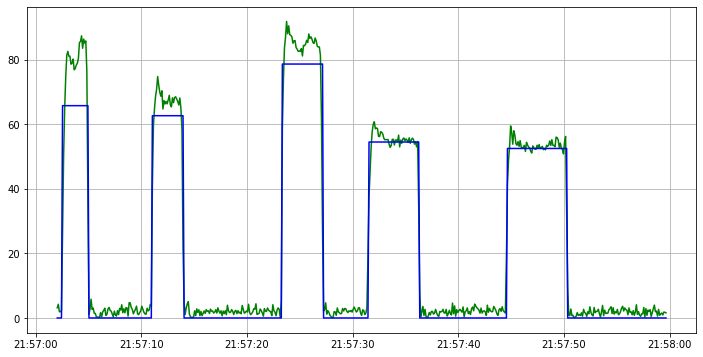

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(df['dt'], df['amperage_mean'], color='green')
ax.plot(df['dt'], df['pred_amperage'], color='blue')
ax.grid(True)
plt.show()

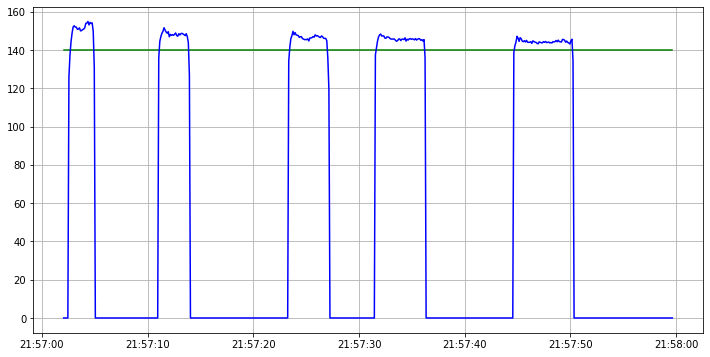

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(df['dt'], df['speed'], color='green')
ax.plot(df['dt'], df['pred_speed'], color='blue')
ax.grid(True)
plt.show()

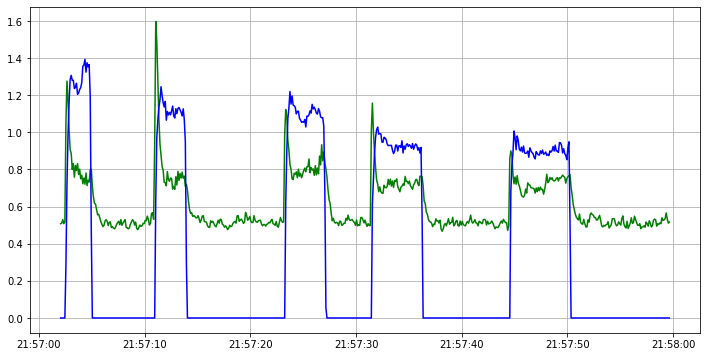

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(df['dt'], df['vibration1_mean'], color='green')
ax.plot(df['dt'], df['pred_vibr_mean'], color='blue')
ax.grid(True)
plt.show()

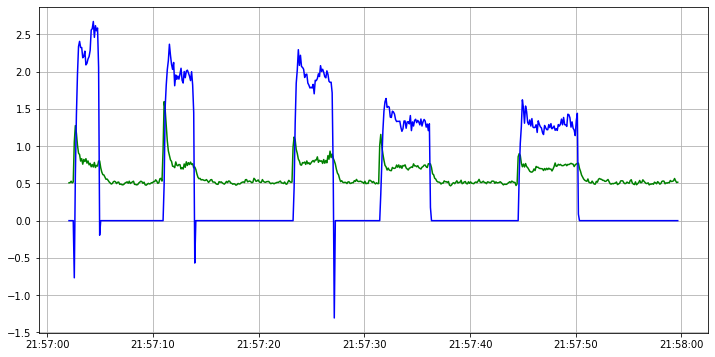

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(df['dt'], df['vibration1_mean'], color='green')
ax.plot(df['dt'], df['pred_vibr_max'], color='blue')
ax.grid(True)
plt.show()

In [115]:
listX

[[0, 872.048828125, 0.4774305522441864, 0.4774305522441864],
 [0, 872.048828125, 0.4962384402751922, 0.4962384402751922],
 [0, 872.048828125, 0.473090261220932, 0.473090261220932],
 [0, 872.048828125, 0.7060185074806213, 0.7060185074806213],
 [0, 872.048828125, 0.7204861044883728, 0.7204861044883728],
 [1, 872.048828125, 0.7320601344108582, 0.7320601344108582],
 [1, 872.048828125, 0.733506977558136, 0.733506977558136],
 [1, 872.048828125, 0.7060185074806213, 0.7060185074806213],
 [1, 872.048828125, 0.7016782760620117, 0.7016782760620117],
 [1, 872.048828125, 0.7364004850387573, 0.7364004850387573],
 [1, 872.048828125, 0.7667824029922485, 0.7667824029922485],
 [1, 872.048828125, 0.7537615895271301, 0.7537615895271301],
 [1, 872.048828125, 0.7364004850387573, 0.7364004850387573],
 [1, 872.048828125, 0.7262731194496155, 0.7262731194496155],
 [1, 872.048828125, 0.7146990895271301, 0.7146990895271301],
 [1, 872.048828125, 0.7320601344108582, 0.7320601344108582],
 [1, 872.048828125, 0.740740

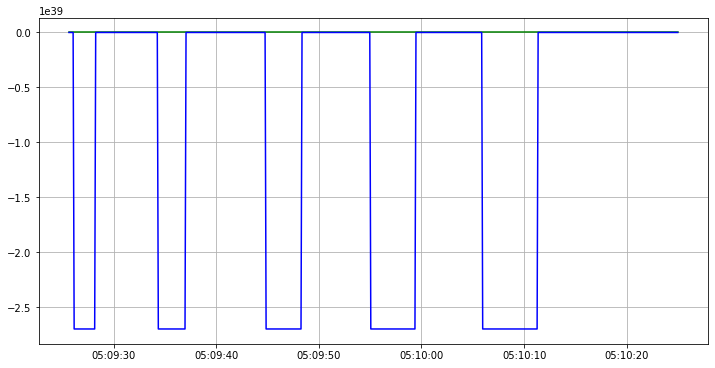

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(df['dt'], df['amperage_mean'], color='green')
ax.plot(df['dt'], df['pred_amperage'], color='blue')
ax.grid(True)
plt.show()

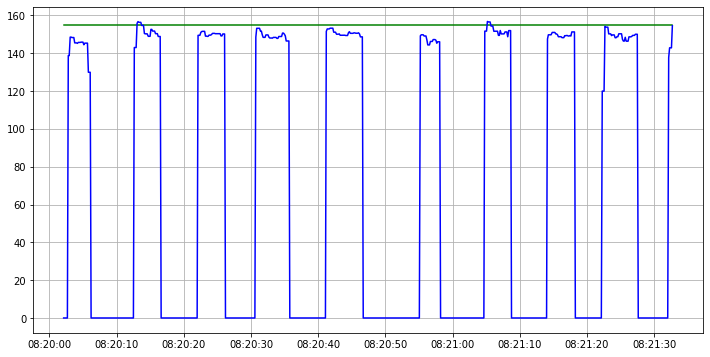

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(df['dt'], df['speed'], color='green')
ax.plot(df['dt'], df['pred_speed'], color='blue')
ax.grid(True)
plt.show()

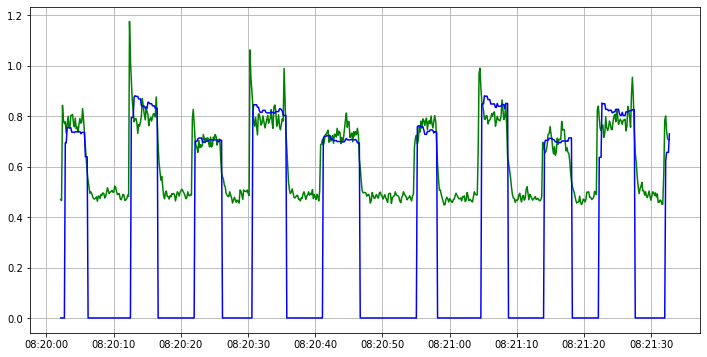

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(df['dt'], df['vibration1_mean'], color='green')
ax.plot(df['dt'], df['pred_vibr_mean'], color='blue')
ax.grid(True)
plt.show()

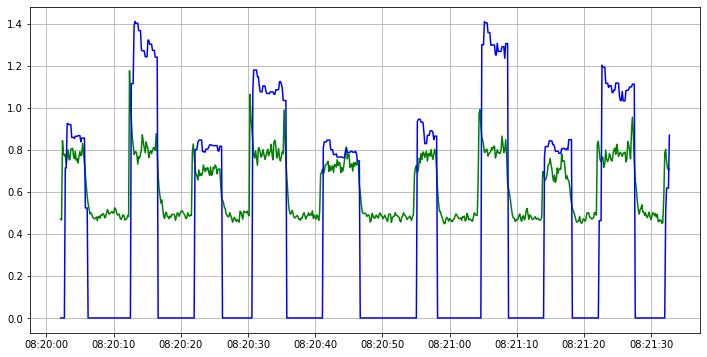

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(df['dt'], df['vibration1_mean'], color='green')
ax.plot(df['dt'], df['pred_vibr_max'], color='blue')
ax.grid(True)
plt.show()

In [117]:
%%time

df.to_csv(os.path.join(path1, 'result.txt'))

CPU times: total: 15.6 ms
Wall time: 11 ms


In [120]:
(df.columns)

Index(['dt', 'amperage_mean', 'temp', 'speed', 'zad_reg', 'vibration1_mean',
       'num_proh', 'count_proh', 'vibr_mean', 'vibr_max', 'num_proh1',
       'num_proh2', 'num_proh3', 'num_proh4', 'num_proh5', 'pred_amperage',
       'pred_temp', 'pred_vibr_mean', 'pred_vibr_max'],
      dtype='object')

In [122]:
path3 = '\\\\192.168.116.16\\users\\st500l1l2\\logs\\stand3_analytics\\models\\T90B_MD250\\regression'

In [127]:
dfregr = pd.read_csv(os.path.join(path3, 'prediction.txt'), sep=',')
dfregr.columns = ['index','dt', 'amperage_mean', 'temp', 'speed', 'zad_reg', 'vibration1_mean',
                                  'num_proh', 'count_proh', 'vibr_mean', 'vibr_max', 'num_proh1', 'num_proh2',
                                  'num_proh3', 'num_proh4', 'num_proh5',
                                  'pred_amperage_mean', 'pred_temp', 'pred_vibration1_mean', 'pred_vibration1_max']

In [128]:
dfregr

,index,dt,amperage_mean,temp,speed,zad_reg,vibration1_mean,num_proh,count_proh,vibr_mean,vibr_max,num_proh1,num_proh2,num_proh3,num_proh4,num_proh5,pred_amperage_mean,pred_temp,pred_vibration1_mean,pred_vibration1_max
0,0,2022-05-16 16:55:57.347,0.134277,851.717468,110.0,1700.000000,0.438368,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
1,1,2022-05-16 16:55:57.488,0.134277,851.717468,110.0,1700.000000,0.755208,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
2,2,2022-05-16 16:55:57.629,11.016846,851.717468,110.0,1700.000000,0.808738,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
3,3,2022-05-16 16:55:57.762,11.016846,851.717468,110.0,1700.000000,0.713252,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
4,4,2022-05-16 16:55:57.897,11.016846,851.717468,110.0,1700.000000,0.766782,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
5,5,2022-05-16 16:55:58.029,52.227783,851.717468,110.0,1700.000000,0.662616,1,1,0.712155,0.840567,1,0,0,0,0,57.580074,992.669434,1.138340,1.626480
6,6,2022-05-16 16:55:58.167,53.283691,851.717468,110.0,1700.000000,0.685764,1,1,0.712155,0.840567,1,0,0,0,0,57.580074,992.366699,1.136444,1.637558
7,7,2022-05-16 16:55:58.307,53.283691,851.717468,110.0,1700.000000,0.666956,1,1,0.712155,0.840567,1,0,0,0,0,57.580074,992.366699,1.136444,1.637558
8,8,2022-05-16 16:55:58.438,53.283691,851.717468,110.0,1700.000000,0.651042,1,1,0.712155,0.840567,1,0,0,0,0,57.580074,992.366699,1.136444,1.637558
9,9,2022-05-16 16:55:58.574,53.344727,851.717468,110.0,1700.000000,0.717593,1,1,0.712155,0.840567,1,0,0,0,0,57.580074,992.349609,1.136333,1.638199
